**кластеризация методом k-means**

Евгений Борисов esborisov@sevsu.ru

# генерируем датасет

In [1]:
import numpy as np
from numpy import random as rng
from sklearn.datasets import make_blobs

In [2]:
n_samples = 500
n_clst = 4 # количество кластеров

X,_ = make_blobs( 
        n_samples=n_samples,
        centers=n_clst,  
        cluster_std=rng.uniform(size=n_clst)+.7
    )
display( X.shape )

(500, 2)

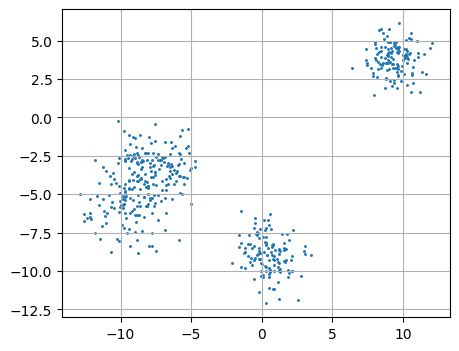

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,4))
plt.scatter(X[:,0],X[:,1],s=1.2)
plt.grid()

# модель кластеризатора

In [4]:
from sklearn.metrics.pairwise import euclidean_distances
from tqdm.auto import tqdm

In [5]:
class KMeansClustering:
    
    def __init__(self,n_centroids=2,metric=euclidean_distances):
        assert n_centroids>1
        self._mu = np.zeros(n_centroids)
        self._metric = metric
                
    def fit(self,X,min_delta=1e-10,n_epoch=500):
        assert len(X)>1
        assert len(X.shape)==2
        self._init_centroids(X)
        for _ in tqdm(range(n_epoch)):
            t = self.predict(X) # сформировать кластеры
            mu = self._mu # сохранить старые центроиды
            self._move_centroid(X,t) # пересчитать центроиды
            if self._stop_cond(mu,min_delta):break
                
        return self 
    
    def _stop_cond(self,mu,min_delta): # проверяем среднее смещение центроидов
        s = (np.diag(self._metric(mu,self._mu)).sum()/len(mu))
        return s < min_delta
        
    def _init_centroids(self,X):
        n = len(self._mu)
        self._mu = X.mean(axis=0) + rng.normal(size=(n,X.shape[1]),scale=.1)
        return self
        
    def _move_centroid(self,X,t): # пересчитываем центроиды
        self._mu = np.vstack([ 
            X[(t==j),:].mean(axis=0) # пересчитываем центроид для кластера j
            if len(X[(t==j)])>0 # если кластер пустой
            else self._mu[j] # то оставляем старый центроид
            for j in set(t) # для всех меток кластеров
        ])
        return self
    
    def predict(self,x):
        assert len(x)>1
        assert x.shape[1]==self._mu.shape[1]
        d = self._metric(X,self._mu) # расстояния от центроидов до всех точек 
        return np.argmin(d,axis=1) # номера кластеров (ближайших центроидов) всех для точек
    
    @property
    def centroids(self):
        return self._mu
            

# тестируем

In [6]:
model = KMeansClustering(n_centroids=n_clst).fit(X) # обучаем модель

  0%|          | 0/500 [00:00<?, ?it/s]

In [7]:
mu = model.centroids
predicted = model.predict(X)

In [8]:
# оценка результата
from sklearn.metrics import silhouette_score

# отношение внутрикластерного и межкластерного расстояний
silhouette_score(X,predicted)

0.766710016225925

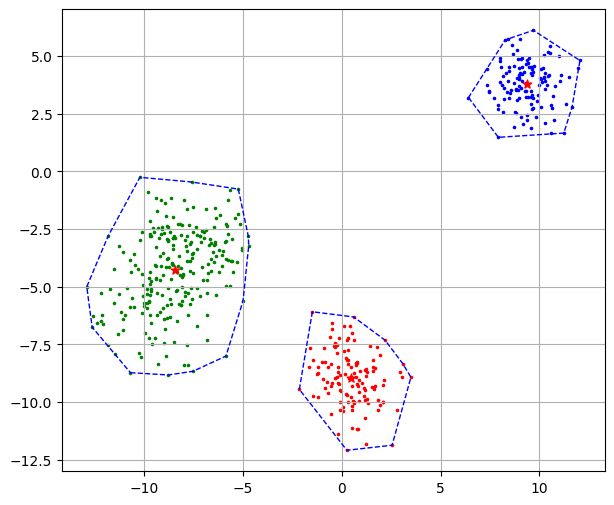

In [9]:
from scipy.spatial import ConvexHull

color_list = 'bgrcmyk'*10 

def hull(x):
    hull = ConvexHull(x) # рисуем выпуклую оболочку вокруг кластера
    v = np.append( hull.vertices, hull.vertices[0] ) # замыкаем оболочку
    plt.plot(x[v,0],x[v,1],'--',lw=1,c='b')

def plot(X,mu,y,figsize=(7,6)):
    plt.figure(figsize=figsize)
    colors = rng.uniform(size=(len(set(y)),3),low=.3,high=1.)
    for j in set(y): 
        plt.scatter( x=X[y==j,0], y=X[y==j,1], s=10, marker='.',c=color_list[j] )
        plt.scatter( x=mu[j,0], y=mu[j,1], s=40, marker='*',c='r' )
        hull(X[y==j])
    plt.grid()

plot(X,mu,predicted) 